In [1]:
import datajoint as dj
import numpy as np
import time

import pandas as pd
import seaborn as sns
sns.set() #sets the asethetics parameters in what set

In [2]:
#setting the address and the username
dj.config['database.host'] = '10.28.0.34'
dj.config['database.user'] = 'celiib'
dj.config['database.password'] = 'newceliipass'
dj.config['safemode']=True
dj.config["display.limit"] = 20

schema = dj.schema('microns_pinky')
pinky = dj.create_virtual_module('pinky', 'microns_pinky')


Connecting celiib@10.28.0.34:3306


In [3]:
#NeuriteTargets was recomputed from the NeuriteRevised list
len(pinky.NeuriteTargetsRevised() & "spine_num<total"),len(pinky.NeuriteTargetsRevised() )

(30088, 30089)

In [4]:
#creates the table with spine data without the spine label
#how to filter out the spine proportion

#have to first remove the ones that have only spine synapses


neurite_targets_no_spine = (pinky.NeuriteTargetsRevised() & "(spine_num + spine_neck_num) <total").proj(
                                                         spine_head_prop="spine_head_prop/(1-spine_prop - spine_neck_prop)",
                                                         shaft_prop="shaft_prop/(1-spine_prop - spine_neck_prop)",
                                                         #non_spine_prop="non_spine_prop/(1-spine_prop - spine_neck_prop)",
                                                         soma_prop = "soma_prop/(1-spine_prop - spine_neck_prop)",
                                                         axon_prop = "axon_prop/(1-spine_prop - spine_neck_prop)",
                                                         total="total-spine_num - spine_neck_num",
                                            )

neurite_targets_no_spine



segmentation segmentation id,segment_id segment id unique within each Segmentation,spine_head_prop calculated attribute,shaft_prop calculated attribute,soma_prop calculated attribute,axon_prop calculated attribute,total calculated attribute
3,648518346341351467,1.0,0.0,0.0,0.0,5.0
3,648518346341351503,1.0,0.0,0.0,0.0,3.0
3,648518346341351508,0.1666666716337204,0.8333333134651184,0.3333333432674408,0.0,6.0
3,648518346341351509,1.0,0.0,0.0,0.0,3.0
3,648518346341351514,0.7500000325962902,0.2500000046566129,0.0,0.0,8.0
3,648518346341351518,1.0000000173846881,0.0,0.0,0.0,6.0
3,648518346341351523,1.000000049670538,0.0,0.0,0.0,3.0
3,648518346341351525,0.8181818203985198,0.18181818772938627,0.0,0.0,11.0
3,648518346341351526,1.0,0.0,0.0,0.0,5.0
3,648518346341351531,1.0,0.0,0.0,0.0,3.0


In [5]:
#different lengths based on the number of synapses threshold

print(len(neurite_targets_no_spine))
print(len(neurite_targets_no_spine & "total>12"))
print(len(neurite_targets_no_spine & "total>10")) 
print(len(neurite_targets_no_spine & "total>8")) 
print(len(neurite_targets_no_spine & "total>6")) 

30084
1320
2351
4365
8664


In [6]:
neurite_targets_no_spine_6 = (neurite_targets_no_spine & "total>6")
print("Total in neurite table with greater than 6 synapses = " + str(len(neurite_targets_no_spine_6)))

Total in neurite table with greater than 6 synapses = 8664


Number of axons with at least 1 Axon synapse = 226, perc = 0.02608494921514312 


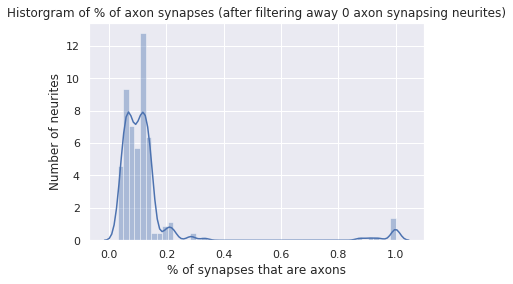

In [24]:
#show the distribution
axon_prop = neurite_targets_no_spine_6.fetch("axon_prop")
axon_prop
axon_greater_0_array = axon_prop[axon_prop.astype("float") > 0]
ax = sns.distplot(axon_greater_0_array.astype("float"))
ax.set(title="Historgram of % of axon synapses (after filtering away 0 axon synapsing neurites)",
      xlabel="% of synapses that are axons",ylabel = "Number of neurites")
print(f"Number of axons with at least 1 Axon synapse = {len(axon_greater_0_array)}, perc = {len(axon_greater_0_array)/len(neurite_targets_no_spine_6)} ")

Number of Neurites with at least 1 Soma synapse = 958, perc = 0.1105724838411819 


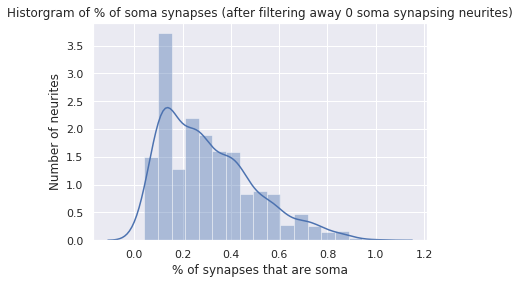

In [25]:
#show the distribution
soma_prop = (neurite_targets_no_spine_6 ).fetch("soma_prop")
soma_prop
soma_greater_0_array = soma_prop[soma_prop.astype("float") > 0]
ax = sns.distplot(soma_greater_0_array.astype("float"))


ax.set(title="Historgram of % of soma synapses (after filtering away 0 soma synapsing neurites)",
       xlabel="% of synapses that are soma",ylabel = "Number of neurites")
print(f"Number of Neurites with at least 1 Soma synapse = {len(soma_greater_0_array)}, perc = {len(soma_greater_0_array)/len(neurite_targets_no_spine_6)} ")

In [15]:
#manually find the groups
""
axon_group = neurite_targets_no_spine_6 & "axon_prop>0"
print("Axon group = " + str(len(axon_group)))
soma_group = (neurite_targets_no_spine_6 - axon_group.proj()) & "soma_prop>=0.25"
print("Soma group = " + str(len(soma_group)))

Axon group = 226
Soma group = 499


Number of Neurites with at least 1 spine_head synapse = 8241, perc = 0.9511772853185596 


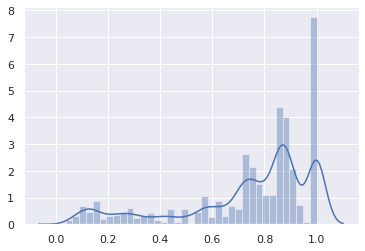

In [23]:
#show the distribution
spine_head_prop = (neurite_targets_no_spine_6 ).fetch("spine_head_prop")
spine_head_prop
spine_head_greater_0_array = spine_head_prop[spine_head_prop.astype("float") > 0]
ax = sns.distplot(spine_head_greater_0_array.astype("float"))


ax.set(title="Historgram of % of spine_head synapses (after filtering away 0 spine_head synapsing neurites)",
       xlabel="% of synapses that are spine_head",ylabel = "Number of neurites")
print(f"Number of Neurites with at least 1 spine_head synapse = {len(spine_head_greater_0_array)}, perc = {len(spine_head_greater_0_array)/len(neurite_targets_no_spine_6)} ")

In [16]:
#remove the axon and soma groups
neurite_targets_no_spine_6_without_axon_soma = neurite_targets_no_spine_6 - axon_group.proj() - soma_group.proj()
len(neurite_targets_no_spine_6_without_axon_soma)/len(neurite_targets_no_spine_6)

0.916320406278855

In [17]:
#get heatmap of the data

neurite_spine_data = neurite_targets_no_spine_6_without_axon_soma.fetch(as_dict=True)

spine_df = pd.DataFrame(neurite_spine_data)
spine_df_base = spine_df.drop(columns=['segmentation', 'segment_id',"total","axon_prop","soma_prop"])
#spine_df_base

In [18]:
#sort by the first column and then do heat map
spine_df_base_head_shaft_sort = spine_df_base.sort_values(['spine_head_prop','shaft_prop'], ascending=[False,True])
spine_df_base_head_shaft_sort

,spine_head_prop,shaft_prop
1342,1.0,0.0
2152,1.0,0.0
3439,1.0,0.0
853,1.0,0.0
3365,1.0,0.0
...,...,...
6354,0.0,1.0
7150,0.0,1.0
7817,0.0,1.0
7832,0.0,1.0


In [19]:
#making the head group
head_group = neurite_targets_no_spine_6_without_axon_soma & "spine_head_prop >=0.6"
len(head_group)

6390

In [20]:
#making the shaft group
shaft_group = (neurite_targets_no_spine_6_without_axon_soma & "shaft_prop >=0.5") - head_group.proj()
len(shaft_group)

1210

In [21]:
unused = neurite_targets_no_spine_6_without_axon_soma - head_group.proj() - shaft_group.proj()

In [22]:
print(len(soma_group),len(axon_group),len(head_group),len(shaft_group),len(unused))
print(sum([len(soma_group),len(axon_group),len(head_group),len(shaft_group),len(unused)]))

499 226 6390 1210 339
8664


In [ ]:
#look up datajoint table that has the clusters
@schema
class SpineClustersKey(dj.Lookup):
    definition="""
    cluster_id : tinyint unsigned #numeric label of cluster
    ---
    description : varchar(16) #descriptive name of cluster
    threshold   : float #the proportion cut off for the group based on the category
    """
    

In [ ]:
cluster_descriptions = ["Soma","Axon","Spine Head","Shaft","Unused"]
cluster_thresholds = [0.25,0.0001,0.6,0.5,0]

clusters_dict = [dict(cluster_id=i,description=cd,threshold=ct) for i,(cd,ct) in enumerate(zip(cluster_descriptions,cluster_thresholds))]
clusters_dict

SpineClustersKey.insert(clusters_dict,skip_duplicates=True)

In [ ]:
SpineClustersKey()

In [ ]:
## Creates the table that holds all of the segment groups
@schema
class SpineClusters(dj.Manual):
    definition="""
    -> pinky.NeuriteRevised
    ---
    ->SpineClustersKey
    """

In [ ]:
possible_groups = [soma_group,axon_group,head_group,shaft_group,unused]
descriptors = [0,1,2,3,4]
for i,table in enumerate(possible_groups):
    new_table = table.proj(cluster_id=str(descriptors[i]))
    SpineClusters.insert(new_table,skip_duplicates=True)
    

In [ ]:
(len(SpineClusters() & "cluster_id=0"),len(SpineClusters() & "cluster_id=1"),
 len(SpineClusters() & "cluster_id=2"),len(SpineClusters() & "cluster_id=3"),
 len(SpineClusters() & "cluster_id=4"))

In [ ]:
print(len(soma_group),len(axon_group),len(head_group),len(shaft_group),len(unused))
print(sum([len(soma_group),len(axon_group),len(head_group),len(shaft_group),len(unused)]))

# SEE IF ADDING CONTACTS THRESHOLD WOULD AFFECT MUCH 

In [ ]:
pinky_fc = dj.create_virtual_module("pinky_fc","microns_pinky_fc")

In [ ]:
pinky.SpineClusters() #segment ids of the chosen Presyns

In [ ]:
presyn_lengths = dj.U("segment_id").aggr(pinky_fc.ContactPrePost.proj("total_postsyn_length"),summed_postsyn_length="sum(total_postsyn_length)")
presyn_lengths

In [ ]:
length_threshold = 100000
presyn_lengths_with_length_threshold  = presyn_lengths & "summed_postsyn_length>" + str(length_threshold)
presyn_lengths_with_length_threshold

In [ ]:
#now restrict the clustering based on the threshold
presyn_lengths_with_length_threshold.proj("segment_id")